In [15]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from utils.data_loader import RadarDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# GPU 메모리 동적 할당
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU 메모리 할당이 동적으로 설정되었습니다.")
    except RuntimeError as e:
        print(f"GPU 메모리 설정 중 오류 발생: {e}")

GPU 메모리 할당이 동적으로 설정되었습니다.


In [17]:
experiment_root = "experiments/Step_03"
model_name = "spectranet_v3"
model_dir = os.path.join(experiment_root, model_name)

DATASET_DIR = "dataset/preprocessed"
label_csv_path = os.path.join(DATASET_DIR, "labels.csv")
split_file_path = os.path.join("splits.pkl")

n_classes = 15
batch_size = 1

input_shapes = {
    'rtm_input': (224,224,3),
    'dtm_input': (224,224,3)
}

class_names = [r"$G_0$", r"$G_1$", r"$G_2$", r"$G_3$", r"$G_4$", r"$G_5$", r"$G_6$", r"$G_7$", r"$G_8$", r"$G_9$", r"$G_{10}$", r"$G_{11}$", r"$G_{12}$", r"$G_{13}$", r"$G_n$"]

In [18]:
def plot_training_curves_separate(history, model_dir, smooth=True, dpi=400, formats=("png","pdf")):
    """정확도와 손실을 각각 개별 그림으로 저장"""
    os.makedirs(model_dir, exist_ok=True)

    def smooth_curve(x):
        window_len = 4
        if len(x) < window_len:
            return x
        s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
        w = np.kaiser(window_len, 2)
        y = np.convolve(w / w.sum(), s, mode='valid')
        half = window_len // 2
        return y[half:len(y)-half]

    def maybe_smooth(x):
        return smooth_curve(x) if smooth else x

    # ---- Accuracy Figure ----
    fig_acc = plt.figure(figsize=(7.5, 5.5))
    plt.plot(maybe_smooth(history.history['accuracy']), label='Train Acc',
             marker='o', markevery=2, markersize=5)
    plt.plot(maybe_smooth(history.history['val_accuracy']), label='Test Acc',
             marker='o', markevery=2, markersize=5)
    plt.xlabel('Epoch', fontsize=18, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=18, fontweight='bold')
    plt.axvline(x=35, linestyle='--', linewidth=1.5, label='LR Drop', color='dimgray')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.5)
    plt.tight_layout()

    for ext in formats:
        plt.savefig(os.path.join(model_dir, f"training_accuracy.{ext}"), dpi=dpi, bbox_inches='tight')
    plt.close(fig_acc)  # 메모리 정리

    # ---- Loss Figure ----
    fig_loss = plt.figure(figsize=(7.5, 5.5))
    plt.plot(maybe_smooth(history.history['loss']), label='Train Loss',
             marker='v', markevery=2, markersize=6)
    plt.plot(maybe_smooth(history.history['val_loss']), label='Test Loss',
             marker='v', markevery=2, markersize=6)
    plt.xlabel('Epoch', fontsize=18, fontweight='bold')
    plt.ylabel('Loss', fontsize=18, fontweight='bold')
    plt.axvline(x=35, linestyle='--', linewidth=1.5, label='LR Drop', color='dimgray')
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.tight_layout()

    for ext in formats:
        plt.savefig(os.path.join(model_dir, f"training_loss.{ext}"), dpi=dpi, bbox_inches='tight')
    plt.close(fig_loss)

In [19]:
class DummyHistory:
    def __init__(self, history_dict):
        self.history = history_dict

with open(os.path.join(model_dir, "history.pkl"), 'rb') as f:
    history_dict = pickle.load(f)

history = DummyHistory(history_dict)

plot_training_curves_separate(history, model_dir=model_dir, smooth=True, dpi=600, formats=("png", "pdf"))

In [20]:
# === 데이터 준비 ===
df = pd.read_csv(label_csv_path)
df['base_id'] = df['file'].apply(lambda x: x.rsplit('_', 1)[0])
base_df = df.drop_duplicates('base_id')
label_map = dict(zip(base_df['base_id'], base_df['label']))

In [21]:
if not os.path.exists(split_file_path):
    base_ids = base_df['base_id'].tolist()
    stratify_labels = [label_map[bid] for bid in base_ids]

    train_base, val_base = train_test_split(
        base_ids,
        test_size=0.2,
        stratify=stratify_labels,
        random_state=47
    )

    split_dict = {'train': train_base, 'val': val_base}
    with open(split_file_path, 'wb') as f:
        pickle.dump(split_dict, f)
    print("[Info] base_id 단위 stratified split (8:2) -> splits.pkl 저장 완료")
else:
    with open(split_file_path, 'rb') as f:
        split_dict = pickle.load(f)
    train_base, val_base = split_dict['train'], split_dict['val']
    print("[Info] splits.pkl 로드 완료")

[Info] splits.pkl 로드 완료


In [22]:
# === Data Loaders ===
val_data   = RadarDataset(val_base, label_map, batch_size=batch_size, data_dir=DATASET_DIR)
val_dataset   = val_data.get_dataset()

In [23]:
from matplotlib.patches import Rectangle

def plot_confusion_matrix00(matrix, save_path, acc=None, loss=None, labels=None):
    matrix = np.array(matrix, dtype=np.float32)

    # 행 기준 정규화
    row_sums = matrix.sum(axis=1, keepdims=True)
    norm_matrix = matrix / np.where(row_sums == 0, 1, row_sums)  # 0으로 나누기 방지

    # 넉넉한 크기로 시작
    fig, ax = plt.subplots(figsize=(12, 12))  # 가로 조금 넓히기

    sns.heatmap(norm_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False, 
                            xticklabels=labels, yticklabels=labels, ax=ax, annot_kws={"size": 13}, linecolor='black', linewidths=0.5)
    

    # 정사각형 셀 비율
    ax.set_aspect('equal')

    ax.tick_params(axis='x',
                bottom=False, labelbottom=False,
                top=True, labeltop=True)

    # X축 글자 각도와 정렬 보정
    ax.set_xticklabels(labels, ha='center', fontsize=20)

    ax.set_yticklabels(labels, rotation=0, fontsize=20)
    
    if acc is not None and loss is not None:
        ax.text(0.5, -0.13,            # (x, y) in axis coordinates
            f"Accuracy: {acc * 100:.2f}%, Loss: {loss:.4f}",
            fontsize=25,
            ha='center',
            transform=ax.transAxes)

    ax.set_xlabel("Predicted Class", fontsize=28, fontweight='bold', labelpad=25)
    ax.set_ylabel("")
    ax.yaxis.set_label_position("right")
    ax.set_ylabel("Original Class", fontsize=28, fontweight='bold', labelpad=25)

    # === 외곽 테두리 수동 추가 ===
    n = matrix.shape[0]
    rect = Rectangle((0, 0), n, n, fill=False, edgecolor='black', linewidth=2)
    ax.add_patch(rect)

    # 간격 보정
    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.2)

    os.makedirs(save_path, exist_ok=True)
    plt.savefig(os.path.join(save_path, "confusion_matrix.png"), dpi=600, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [24]:
print(f"\n[테스트 평가] {model_name}")

# 모델 로드
best_model = load_model(os.path.join(model_dir, "best_model.keras"))

# 평가
loss, acc = best_model.evaluate(val_dataset, verbose=1)

# Confusion Matrix 계산
y_true, y_pred = [], []
for batch_x, batch_y in val_dataset:
    preds = best_model.predict(batch_x, verbose=0)
    y_true.extend(batch_y.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)


[테스트 평가] spectranet_v3
540/540 [==============================] - 6s 7ms/step - loss: 1.3607e-04 - accuracy: 1.0000


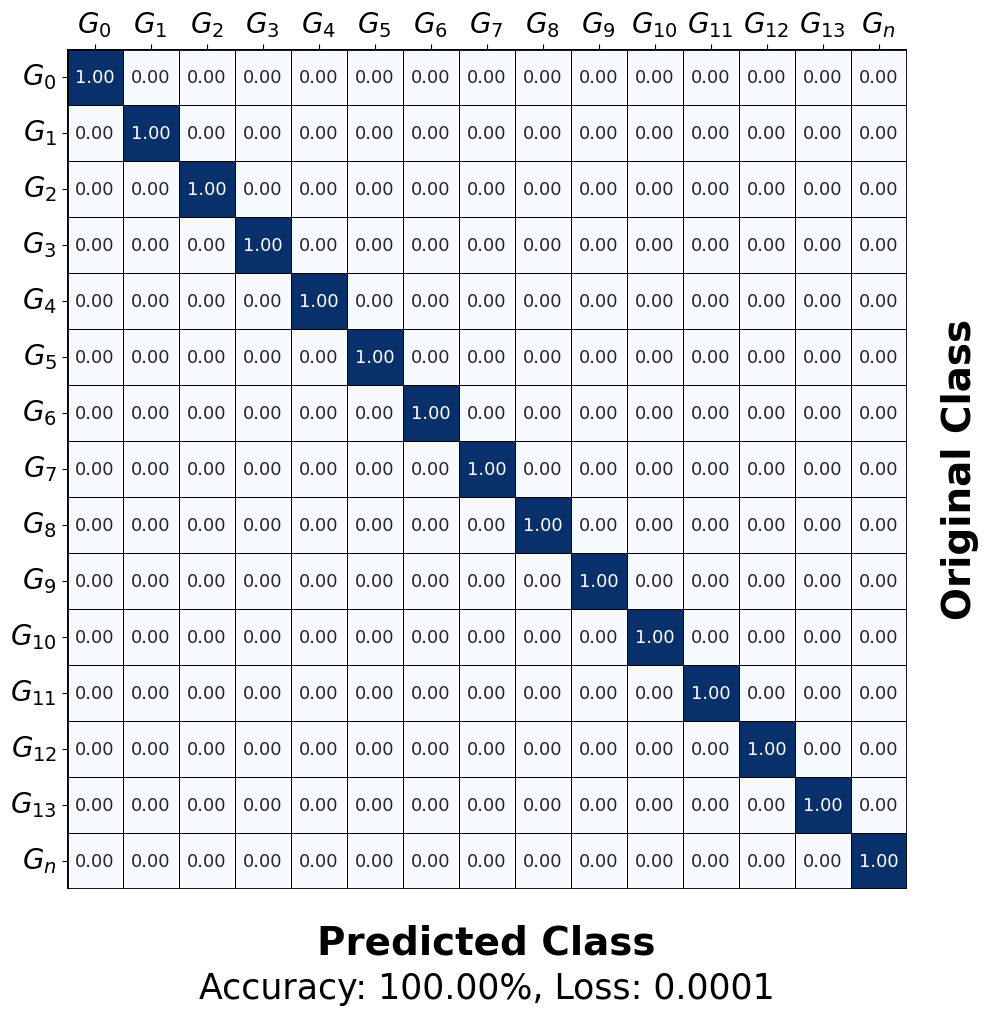

[DONE] spectranet_v3 acc=1.0000, loss=0.0001


In [25]:
# 결과 저장
plot_confusion_matrix00(cm, save_path=model_dir, acc=acc, loss=loss, labels=class_names)

print(f"[DONE] {model_name} acc={acc:.4f}, loss={loss:.4f}")

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

# ================= CONFIG =================
SAMPLE_ID = "GDN_6_s3_v1_003_D"
PREPROCESS_DIR = "dataset/preprocessed_sample"
SAVE_DIR = "plots_rx0_aug_fixed"
os.makedirs(SAVE_DIR, exist_ok=True)

rtm_path = os.path.join(PREPROCESS_DIR, f"{SAMPLE_ID}_rtm.npy")
dtm_path = os.path.join(PREPROCESS_DIR, f"{SAMPLE_ID}_dtm.npy")

# ================= LOAD =================
rtm = np.load(rtm_path)
dtm = np.load(dtm_path)
rtm_rx0 = rtm[:, :, 0]
dtm_rx0 = dtm[:, :, 0]
print(f"[Loaded] {SAMPLE_ID}")

# ================= 기존 시각화 함수 그대로 =================
def save_with_axes(img, save_path, is_rtm=True):
    plt.figure(figsize=(3.8, 3.8))
    ax = plt.gca()
    x_max = 4.0

    if is_rtm:
        extent = [0, x_max, 0.0, 1.745]
        ax.imshow(img, cmap='turbo', origin='lower', extent=extent, aspect='auto')
        ax.invert_yaxis()

        yticks_pos = [0.0, 0.5, 1.0, 1.5]
        ax.set_yticks(yticks_pos)
        ax.set_yticklabels(["0.0", "0.5", "1.0", "1.5"])
        ax.set_ylabel("Range [m]", fontsize=14, fontweight='bold', labelpad=2)
    else:
        v_max = 4.115
        extent = [0, x_max, -v_max, v_max]
        ax.imshow(img, cmap='turbo', origin='upper', extent=extent, aspect='auto')
        ax.set_ylim(-v_max, v_max)
        ax.set_yticks([4, 2, 0, -2, -4])
        ax.set_yticklabels(["-4", "-2", "0", "2", "4"])
        ax.set_ylabel("Velocity (m/s)", fontsize=14, fontweight='bold', labelpad=2)

    ax.set_xlim(0, x_max)
    ax.set_xticks([0, 2, 4])
    ax.set_xlabel("Time [s]", fontsize=14, fontweight='bold', labelpad=2)

    ax.set_box_aspect(1)
    ax.tick_params(axis='both', which='major', labelsize=14, pad=2)
    plt.subplots_adjust(left=0.16, right=0.98, bottom=0.16, top=0.98)
    plt.savefig(save_path, dpi=600)
    plt.close()


# ================= 고정 증강 함수 =================
def apply_fixed_augmentations(rtm, dtm):
    rtm = tf.convert_to_tensor(rtm[..., None], dtype=tf.float32)
    dtm = tf.convert_to_tensor(dtm[..., None], dtype=tf.float32)

    # --- 증강 1: RTM Vertical Shift (-30 pixel) ---
    shift = -30
    if shift < 0:
        rtm_shifted = tf.concat([rtm[-shift:, :, :], tf.zeros([-shift, 224, 1])], axis=0)
    else:
        rtm_shifted = tf.concat([tf.zeros([shift, 224, 1]), rtm[:-shift, :, :]], axis=0)

    # --- 증강 2: Horizontal Stretch (0.7x) ---
    scale_x = 0.7
    new_width = tf.cast(224 * scale_x, tf.int32)
    rtm_stretch_x = tf.image.resize(rtm, (224, new_width))
    dtm_stretch_x = tf.image.resize(dtm, (224, new_width))
    rtm_stretch_x = tf.image.resize_with_crop_or_pad(rtm_stretch_x, 224, 224)
    dtm_stretch_x = tf.image.resize_with_crop_or_pad(dtm_stretch_x, 224, 224)

    # --- 증강 3: DTM Vertical Stretch (1.3x) ---
    scale_y = 1.3
    mid = 112
    top = dtm[:mid, :, :]
    bottom = dtm[mid:, :, :]
    new_top = tf.image.resize(top, (tf.cast(mid * scale_y, tf.int32), 224))
    new_bottom = tf.image.resize(bottom, (tf.cast((224 - mid) * scale_y, tf.int32), 224))
    dtm_stretch_y = tf.concat([new_top, new_bottom], axis=0)
    dtm_stretch_y = tf.image.resize_with_crop_or_pad(dtm_stretch_y, 224, 224)

    return (
        tf.squeeze(rtm_shifted).numpy(),  # 증강1
        tf.squeeze(rtm_stretch_x).numpy(),  # 증강2 RTM
        tf.squeeze(dtm_stretch_x).numpy(),  # 증강2 DTM
        tf.squeeze(dtm_stretch_y).numpy(),  # 증강3
    )


# ================= 증강 적용 =================
rtm_aug1, rtm_aug2, dtm_aug2, dtm_aug3 = apply_fixed_augmentations(rtm_rx0, dtm_rx0)

# ================= 저장 =================
save_with_axes(rtm_rx0, os.path.join(SAVE_DIR, f"{SAMPLE_ID}_rtm_original.png"), is_rtm=True)
save_with_axes(dtm_rx0, os.path.join(SAVE_DIR, f"{SAMPLE_ID}_dtm_original.png"), is_rtm=False)

save_with_axes(rtm_aug1, os.path.join(SAVE_DIR, f"{SAMPLE_ID}_rtm_aug1_vertical(-30).png"), is_rtm=True)
save_with_axes(rtm_aug2, os.path.join(SAVE_DIR, f"{SAMPLE_ID}_rtm_aug2_horizontal(0.7).png"), is_rtm=True)
save_with_axes(dtm_aug2, os.path.join(SAVE_DIR, f"{SAMPLE_ID}_dtm_aug2_horizontal(0.7).png"), is_rtm=False)
save_with_axes(dtm_aug3, os.path.join(SAVE_DIR, f"{SAMPLE_ID}_dtm_aug3_vertical(1.3).png"), is_rtm=False)

print(f"[All Saved in] {SAVE_DIR}")


[Loaded] GDN_6_s3_v1_003_D
[All Saved in] plots_rx0_aug_fixed
